In [1]:
%%capture
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip install pyvirtualdisplay
!pip install pyglet==1.5.1
!pip install gymnasium
!pip install git+https://github.com/ntasfi/PyGame-Learning-Environment.git git+https://github.com/simoninithomas/gym-games imageio-ffmpeg pyyaml==6.0

In [2]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [3]:
import numpy as np

from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import HTML, clear_output

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gymnasium as gym
import gym_pygame
from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit

import imageio

In [4]:
def plot(
        episode,
        scores,
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(10, 5))
        plt.title('frame %s. score: %s' % (episode, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.show()

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
print(device)

cpu


In [7]:
def create_environment(name):
    env = gym.make(name, max_episode_steps=200, render_mode="rgb_array")
    env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda x: x % 50 == 0)
    env = RecordEpisodeStatistics(env)
    return env

In [8]:
env_id = "CartPole-v1"
# Create the env
env = create_environment(env_id)
# Create the evaluation env
eval_env = create_environment(env_id)

# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [9]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  4
Sample observation [2.1981258  2.130518   0.09642056 0.1548852 ]


In [10]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

The Action Space is:  2
Action Space Sample 1


In [11]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

### Let's build the Reinforce Training Algorithm
This is the Reinforce algorithm pseudocode:

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit6/pg_pseudocode.png" alt="Policy gradient pseudocode"/>
  



- We want to maximize our utility function $J(\theta)$ but in PyTorch like in Tensorflow it's better to **minimize an objective function.**
    - So let's say we want to reinforce action 3 at a certain timestep. Before training this action P is 0.25.
    - So we want to modify $\theta$ such that $\pi_\theta(a_3|s; \theta) > 0.25$
    - Because all P must sum to 1, max $\pi_\theta(a_3|s; \theta)$ will **minimize other action probability.**
    - So we should tell PyTorch **to min $1 - \pi_\theta(a_3|s; \theta)$.**
    - This loss function approaches 0 as $\pi_\theta(a_3|s; \theta)$ nears 1.
    - So we are encouraging the gradient to max $\pi_\theta(a_3|s; \theta)$


In [16]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    scores = []
    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()[0]
        # Line 4 of pseudocode
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _, = env.step(action)
            rewards.append(reward)
            if done:
                break
        scores.append(sum(rewards))

        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)

        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft( gamma*disc_return_t + rewards[t]   )

        ## standardization of the returns is employed to make training more stable
        eps = np.finfo(np.float32).eps.item()
        ## eps is the smallest representable float, which is
        # added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        # Line 8: PyTorch prefers gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            plot(len(scores), scores)

    return scores

In [17]:
cartpole_hyperparameters = {
    "h_size": 16,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [18]:
# Create policy and place it to the device
cartpole_policy = Policy(cartpole_hyperparameters["state_space"], cartpole_hyperparameters["action_space"], cartpole_hyperparameters["h_size"]).to(device)
cartpole_optimizer = optim.Adam(cartpole_policy.parameters(), lr=cartpole_hyperparameters["lr"])

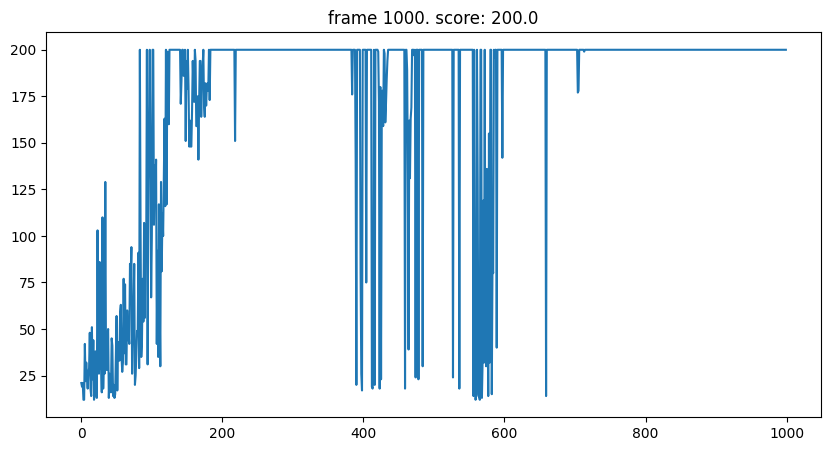

In [19]:
scores = reinforce(cartpole_policy,
                   cartpole_optimizer,
                   cartpole_hyperparameters["n_training_episodes"],
                   cartpole_hyperparameters["max_t"],
                   cartpole_hyperparameters["gamma"],
                   100)